<a href="https://colab.research.google.com/github/s0yabean/ds_portfolio/blob/master/CNN_Classifier_YOGA_Pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification on Yoga Poses Using VGG Neural Network

Yoga is a sport that has gained increasing popularity in recent years. 

With advances in computer vision, we would expect computers to be able to recognize Yoga poses and even be able to teach humans in the near future.

In this notebook, I have created a neural network that classifies 3 Yoga Poses, with an accuracy of up to 90%.

In [0]:
#Loading all packages and plotting functions
%matplotlib inline
import matplotlib.pyplot as plt
import os, json
from IPython.display import Image, clear_output
from PIL import Image as pilImage

import tensorflow.keras
import tensorflow as tf

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard

from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator

import glob
import pandas as pd
import numpy as np

tf.enable_eager_execution()

In [0]:
print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
1.13.1


### Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU
 

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Checking directory works
ls '/content/gdrive/My Drive/yoga_ai'

models/  train/


In [0]:
train_dir = '/content/gdrive/My Drive/yoga_ai/train'

# Data Pre-processing (Removing faulty images, resizing, transformations etc)

In [0]:
# Standardising all file formats to JPG for easy tensorflow running

In [0]:
# AFTER DOWNLOADING GOOGLE IMAGES FROM FATKUN CHROME EXTENSION, I NOTICED THERE WERE NON-JPG FILES THAT NEEDED PROCESSING.
# VERY IMPORTANT FUNCTION - TO CONVERT ALL WORKING IMAGES TO JPG AND DELETE ANY OTHER FILES (LIKE GIFS AND HTML)
def extract_jpg(dir, name):
  fn = os.listdir(dir)

  for i in range(len(fn)):
    
    clear_output(wait=True)
    
    if fn[i][-3:] == 'jpg':
      os.rename(dir + '/' + fn[i], dir + '/' + name + '_' + str(i) + '.jpg')
    else: 
      try:
        im = pilImage.open(dir + '/' + fn[i])
        im.convert('RGB').save(dir + '/' + name + '_' + str(i) + '.jpg')
        os.remove(dir + '/' + fn[i])
      except:
        print(fn[i] + ' file is problematic - deleting')
        os.remove(dir + '/' + fn[i])
        continue
        
    print("Current Progress:", np.round(i/len(fn) * 100, 2), "%")
        
  initial = len(fn)
  final = len(glob.glob(dir + '/*.jpg'))
  print(str(initial - final) + ' files deleted to have ' + str(final) + ' images. ')
  return glob.glob(dir + '/*.jpg')
   

In [0]:
# VERY IMPORTANT FUNCTION - TO REMOVE ERRONEOUS IMAGES THAT CANNOT BE SEEN EASILY FROM THE GUI
# for i in filenames_n2:
#   image_string = tf.read_file(i)
#   image_decoded = tf.cond(
#       tf.image.is_jpeg(image_string),
#       lambda: None,
#       lambda: print(i))

In [0]:
# RUNNING THESE FUNCTIONS AFTER RUNNING THE EXTRACT_JPG FUNCTION 2 CELLS ABOVE

filenames_n0 = glob.glob(train_dir + '/garland_pose/*.jpg')
filenames_n1 = glob.glob(train_dir + '/downward_dog/*.jpg')
filenames_n2 = glob.glob(train_dir + '/reverse_warrior/*.jpg')

names = ['garland_pose', 'downward_dog', 'reverse_warrior']

print('Total Data Available:')
len(filenames_n0) + len(filenames_n1) + len(filenames_n2)

Total Data Available:


793

# Creation of tensorflow data object

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])
df3 = pd.DataFrame(filenames_n2, columns = ["filename"])

# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)

# Split into train and validation sets
train_set_percentage = .8

train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

df_new_train = pd.concat([train_df, train_df2, train_df3])
df_new_val = pd.concat([val_df, val_df2, val_df3])

# shuffle 
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [0]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 3

df.shape

(633, 2)

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
#  image_decoded = tf.image.decode_image(image_string)
#   image_decoded = tf.cond(
#       tf.image.is_jpeg(image_string),
#       lambda: tf.image.decode_jpeg(image_string, channels=3),
#       lambda: tf.image.decode_png(image_string, channels=3))
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of filenames - from a list
# Labels that match the training files - from a list
filenames = tf.constant(train_filenames_list)
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [0]:
#prefetch the data of batches 32 so that they are ready and not wasting GPU resources.
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

# Visualising of Images

The 3 classes are downward dog, garland pose and reverse warrior.

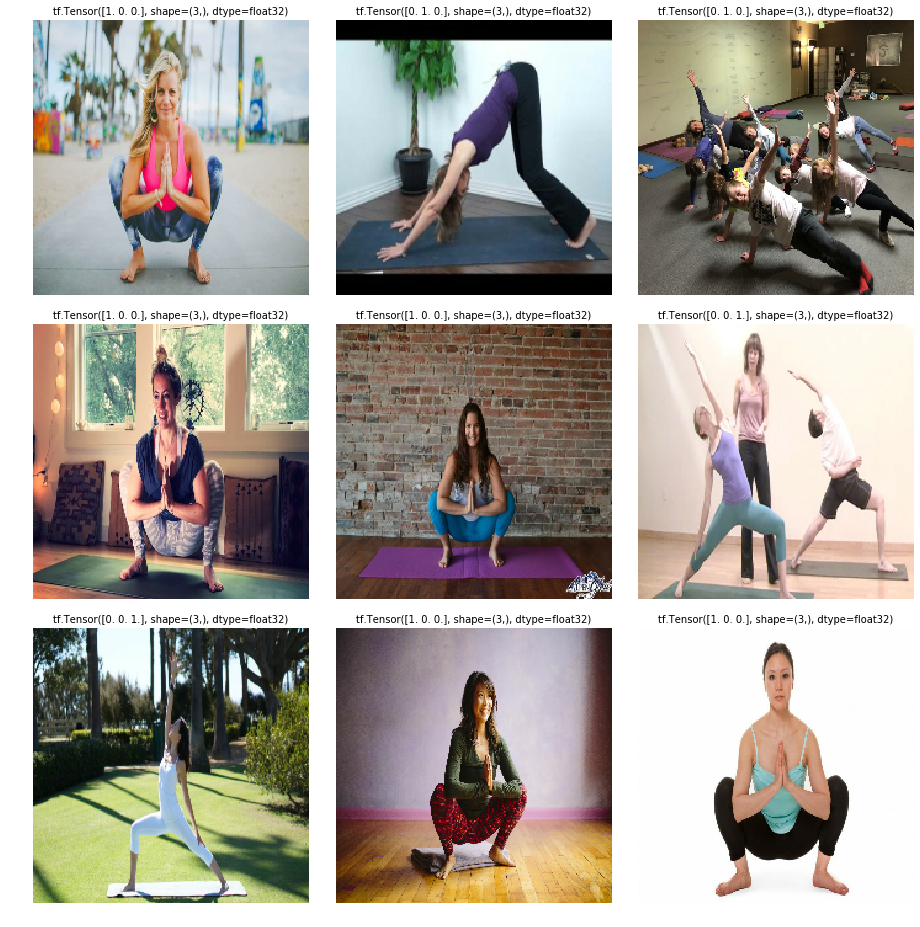

In [0]:
for batch in train_dataset:
    image_batch, label_batch = batch[0], batch[1]
    
    plt.figure(figsize=(13,13))
    subplot=331
    for i,image in enumerate(image_batch):
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image.numpy().astype(np.uint8))
      plt.title(label_batch[i] , fontsize=10)
      subplot += 1
      if i==8:
        break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    break


# Loading the imagenet model

In [0]:
# create the base pre-trained model
# include_top false just means remove the top layer that does the imagenet classification (that of which it was trained on)
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [0]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# add a global spatial average pooling layer
x = base_model.output

# Adaptive Pooling - averaging out what is coming out of the model.
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 2 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
len(model.layers)

22

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name) 
    layer.trainable = False


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_2
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_1
True
dense_2
True
dense_3
True


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
train_steps = int(len(df)/32) #total trains set / batch_size
val_steps = int(len(df_val)/32)

In [0]:
#checkpoint = ModelCheckpoint('/content/gdrive/My Drive/yoga_ai/weights/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

In [0]:
# # # Train the model with validation 
history = model.fit(train_dataset, 
                     steps_per_epoch = train_steps,
                     epochs = 10,
                     validation_data = valid_dataset,
                     validation_steps = val_steps,
                     callbacks=[checkpoint])

Epoch 1/10
5/5 [==============================] - 2s 352ms/step - loss: 0.7334 - acc: 0.8562

Epoch 00001: val_loss did not improve from 0.57039
19/19 [==============================] - 13s 666ms/step - loss: 0.0490 - acc: 0.9901 - val_loss: 0.7334 - val_acc: 0.8562
Epoch 2/10
5/5 [==============================] - 2s 353ms/step - loss: 0.8931 - acc: 0.8375

Epoch 00002: val_loss did not improve from 0.57039
19/19 [==============================] - 12s 632ms/step - loss: 0.0521 - acc: 0.9901 - val_loss: 0.8931 - val_acc: 0.8375
Epoch 3/10
5/5 [==============================] - 2s 349ms/step - loss: 1.2124 - acc: 0.7750

Epoch 00003: val_loss did not improve from 0.57039
19/19 [==============================] - 12s 627ms/step - loss: 0.0460 - acc: 0.9934 - val_loss: 1.2124 - val_acc: 0.7750
Epoch 4/10
5/5 [==============================] - 2s 350ms/step - loss: 0.7525 - acc: 0.8500

Epoch 00004: val_loss did not improve from 0.57039
19/19 [==============================] - 12s 613ms/ste

In [0]:
model.save_weights('/content/gdrive/My Drive/yoga_ai/weights/my_model_weights.h5')

In [0]:
# !ls '/content/gdrive/My Drive/yoga_ai/weights'

my_model_weights.h5


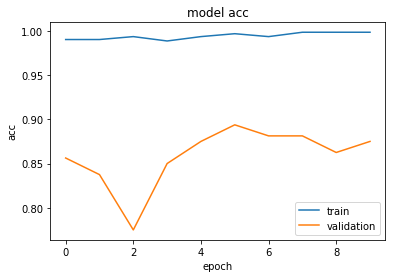

In [0]:
# PLOTTING GRAPH TO SEE RELATIONSHIP BETWEEN TRAINING AND VALIDATION DATA
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    
plot_train(history)

In [0]:
model.load_weights('/content/gdrive/My Drive/yoga_ai/weights/my_model_weights.h5')
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 18s 359ms/step - loss: 0.6589 - acc: 0.8750
model accuracy: 0.875
